# **Импорты**

In [ ]:
import functools
from math import atan2
import matplotlib.pyplot as plt
from random import randint
import numpy as np
from tqdm import tqdm
import time

# **Дополнительные функции**

In [ ]:
def generate_random_points(num_points=200, percent_uniform=25, low_concentrated=0, high_concentrated=9000,  low_uniform=0, high_uniform=10000):
    """
    Генерация случайных точек с менее концентрированным распределением и выбросами.
    Параметры:
    - num_points: Количество всех точек.
    - percent_uniform: Процент точек с равномерным распределением (выбросы).
    - low_concentrated: Нижняя граница для концентрированных точек.
    - high_concentrated: Верхняя граница для концентрированных точек.
    - low_uniform: Нижняя граница для равномерных точек (выбросы).
    - high_uniform: Верхняя граница для равномерных точек (выбросы).
    Возвращает:
    Список кортежей, представляющих собой сгенерированные точки.
    """
    num_uniform = int((num_points * percent_uniform) / 100)

    concentrated_points = np.random.randint(low=low_concentrated, high=high_concentrated, size=(num_points-num_uniform, 2))
    uniform_points = np.random.randint(low=low_uniform, high=high_uniform, size=(num_uniform, 2))

    points = np.concatenate((concentrated_points, uniform_points))

    return [tuple(point) for point in points]

In [ ]:
def rotate_points(points, angle_degrees):
    """
    Трансформирует точки графика путем поворота на указанный угол.
    Параметры:
    - points: список кортежей (x, y), представляющих точки графика
    - angle_degrees: угол поворота в градусах
    Возвращает:
    Список кортежей с трансформированными точками.
    """
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                [np.sin(angle_radians), np.cos(angle_radians)]])

    transformed_points = [np.dot(rotation_matrix, np.array(point)) for point in points]

    return [(point[0], point[1]) for point in transformed_points]

In [ ]:
def check_points_on_line_x(points):
    """
    Проверяет, лежат ли все точки на одной горизонтальной линии.
    Параметры:
    - points: список кортежей (x, y), представляющих точки
    Возвращает:
    True, если все точки лежат на одной горизонтальной линии, иначе False.
    """
    # Извлекаем координаты X из всех точек
    x_values = [x for x, y in points]

    # Проверяем, все ли значения X равны первому значению X
    return all(x == x_values[0] for x in x_values)

In [ ]:
def quick_hull_old(points):
    """
    Функция для поиска выпуклой оболочки методом "Быстрая оболочка".
    Возвращает упорядоченный список точек, составляющих выпуклую оболочку.
    """
    def orientation(p, q, r):
        """
        Функция определяет ориентацию трех точек (p, q, r).
        Возвращает:
        - -1, если точки образуют левый поворот (против часовой стрелки).
        -  0, если точки коллинеарны.
        -  1, если точки образуют правый поворот (по часовой стрелке).
        """
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else -1

    def find_distance(p, q, r):
        """
        Функция вычисляет расстояние от точки r до прямой, проходящей через точки p и q.
        Возвращает абсолютное значение этого расстояния.
        """
        return abs((q[1] - p[1]) * (r[0] - p[0]) - (q[0] - p[0]) * (r[1] - p[1]))

    def find_hull(points, p, q, side):
        """
        Рекурсивная функция для поиска выпуклой оболочки.
        points - множество точек,
        p, q - текущие точки, образующие линию,
        result_hull - текущая выпуклая оболочка.
        """

        ind = -1
        max_dist = 0

        # Нахождение точки с максимальным расстоянием от L, а также на указанной стороне L.
        for i in range(len(points)):
            temp = find_distance(p, q, points[i])

            if (orientation(p, q, points[i]) == side) and (temp > max_dist):
                ind = i
                max_dist = temp

        # Если точка не найдена, добавьте конечные точки L к выпуклой оболочке.
        if ind == -1:
            result_hull.add("$".join(map(str, p)))
            result_hull.add("$".join(map(str, q)))
            return

        # Рекусрсия для двух частей, разделенных [ind]
        find_hull(points, points[ind], p, -orientation(points[ind], p, q))
        find_hull(points, points[ind], q, -orientation(points[ind], q, p))

    n = len(points)
    if n < 3:
        #print("Множество точек содержит менее трех точек. Невозможно построить выпуклую оболочку.")
        return points

    result_hull = set()

    # Сортируем точки по координате x, затем по y в порядке убывания
    sorted_points = sorted(points, key=lambda x: (x[0], -x[1]))

    # Находим самую левую нижнюю и самую правую верхнюю точки
    min_x = min(enumerate(points), key=lambda x: (x[1][0], x[1][1]))[0]
    max_x = max(enumerate(points), key=lambda x: (x[1][0], x[1][1]))[0]

    # Рекурсивно найти точки выпуклой оболочки на одной и другой стороне линии, соединяющей a[min_x] и a[max_x]
    find_hull(points, points[min_x], points[max_x], 1)
    find_hull(points, points[min_x], points[max_x], -1)

    convex_hull = []
    for element in result_hull:
        x = element.split("$")
        convex_hull.append((float(x[0]), float(x[1])))

    # Сортируем остальные точки по полярному углу относительно самой левой
    sorted_points = sorted(convex_hull, key=lambda point: (atan2(point[1] - points[min_x][1], point[0] - points[min_x][0]), point))

    if points[min_x] in sorted_points:
      sorted_points.remove(points[min_x])
      sorted_points.insert(0, points[min_x])

    return sorted_points

# **Выпуклые оболочки**

## Метод Грэхема

In [ ]:
def graham_scan(points):
    """
    Функция для поиска выпуклой оболочки методом "Алгоритм Грэхема".
    Возвращает упорядоченный список точек, составляющих выпуклую оболочку.
    """
    def orientation(p, q, r):
        """
        Функция определяет ориентацию трех точек (p, q, r).
        Возвращает:
        - -1, если точки образуют левый поворот (против часовой стрелки).
        -  0, если точки коллинеарны.
        -  1, если точки образуют правый поворот (по часовой стрелке).
        """
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else -1

    n = len(points)
    if n < 3:
        #print("Множество точек содержит менее трех точек. Невозможно построить выпуклую оболочку.")
        return points

    # Находим точку с наименьшей y-координатой (и самой левой, если таких несколько)
    p0 = min(points, key=lambda x: (x[1], x[0]))

    # Сортируем остальные точки по полярному углу относительно p0
    sorted_points = sorted(points, key=lambda point: (atan2(point[1]-p0[1], point[0]-p0[0]), point))

    # Инициализируем стек и добавляем первые три точки
    convex_hull = [sorted_points[0], sorted_points[1], sorted_points[2]]

    for i in range(2, n):
        # Пока точка не образует левый поворот, удаляем последнюю точку из стека
        while len(convex_hull) >= 2 and orientation(convex_hull[-2], convex_hull[-1], sorted_points[i]) != -1:
            convex_hull.pop()

        # Добавляем текущую точку в стек
        convex_hull.append(sorted_points[i])

    return convex_hull

## Модифицированный Метод Грэхема

In [ ]:
def graham_scan_modified(points):
    """
    Функция для поиска выпуклой оболочки методом "Модифицированный алгоритм Грэхема".
    Возвращает:
    - Упорядоченный список точек, составляющих верхную часть оболочки.
    - Упорядоченный список точек, составляющих нижнюю часть оболочки.
    - Упорядоченный список точек, составляющих всю выпуклую оболочку.
    """
    def orientation(p, q, r):
        """
        Функция определяет ориентацию трех точек (p, q, r).
        Возвращает:
        - -1, если точки образуют левый поворот (против часовой стрелки).
        -  0, если точки коллинеарны.
        -  1, если точки образуют правый поворот (по часовой стрелке).
        """
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else -1

    def find_upper_hull(sorted_points):
      """
      Функция находит часть выпуклой оболочки для упорядоченного списка точек sorted_points, который представляет собой часть выпуклой оболочки.
      Возвращает список точек, представляющий одну часть выпуклой оболочки.
      """
      upper_hull = []
      for point in sorted_points:
          while len(upper_hull) >= 2 and orientation(upper_hull[-2], upper_hull[-1], point) != 1:
              upper_hull.pop()
          upper_hull.append(point)
      return upper_hull

    n = len(points)
    if n < 3:
        #print("Множество точек содержит менее трех точек. Невозможно построить выпуклую оболочку.")
        return points

    # Сортируем точки по координате x, затем по y в порядке убывания
    sorted_points = sorted(points, key=lambda x: (x[0], -x[1]))

    # Модификация: строим верхнюю и нижнюю выпуклости
    upper_hull = find_upper_hull(sorted_points)
    lower_hull = find_upper_hull(reversed(sorted_points))

    # Соединяем верхнюю и нижнюю выпуклости для получения общей выпуклой оболочки
    convex_hull = upper_hull[:-1] + lower_hull[:-1]

    return upper_hull, lower_hull, convex_hull

## Метод быстрой оболочки

In [ ]:
def quick_hull(points):
    """
    Функция для поиска выпуклой оболочки методом "Быстрая оболочка".
    Возвращает упорядоченный список точек, составляющих выпуклую оболочку.
    """
    def orientation(p, q, r):
        """
        Функция определяет ориентацию трех точек (p, q, r).
        Возвращает:
        - -1, если точки образуют левый поворот (против часовой стрелки).
        -  0, если точки коллинеарны.
        -  1, если точки образуют правый поворот (по часовой стрелке).
        """
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else -1

    def find_distance(p, q, r):
        """
        Функция вычисляет расстояние от точки r до прямой, проходящей через точки p и q.
        Возвращает абсолютное значение этого расстояния.
        """
        return abs((q[1] - p[1]) * (r[0] - p[0]) - (q[0] - p[0]) * (r[1] - p[1]))

    def find_hull(points, p, q, side):
        """
        Рекурсивная функция для поиска выпуклой оболочки.
        points - множество точек,
        p, q - текущие точки, образующие линию,
        result_hull - текущая выпуклая оболочка.
        """
        ind = -1
        max_dist = 0

        # Нахождение точки с максимальным расстоянием от L, а также на указанной стороне L.
        for i in range(len(points)):
            temp = find_distance(p, q, points[i])

            if (orientation(p, q, points[i]) == side) and (temp > max_dist):
                ind = i
                max_dist = temp

        # Если точка не найдена, добавьте конечные точки L к выпуклой оболочке.
        if ind == -1:
            result_hull.append(p)
            result_hull.append(q)
            return

        # Рекусрсия для двух частей, разделенных [ind]
        find_hull(points, points[ind], p, -orientation(points[ind], p, q))
        find_hull(points, points[ind], q, -orientation(points[ind], q, p))

    n = len(points)
    if n < 3:
        #print("Множество точек содержит менее трех точек. Невозможно построить выпуклую оболочку.")
        return points

    result_hull = []

    # Сортируем точки по координате x, затем по y в порядке убывания
    sorted_points = sorted(points, key=lambda x: (x[0], -x[1]))

    # Находим самую левую нижнюю и самую правую верхнюю точки
    min_x = min(points, key=lambda x: (x[0], x[1]))
    max_x = max(points, key=lambda x: (x[0], x[1]))

    # Рекурсивно найти точки выпуклой оболочки на одной и другой стороне линии, соединяющей a[min_x] и a[max_x]
    find_hull(points, min_x, max_x, 1)
    find_hull(points, min_x, max_x, -1)

    # Удаление дубликатов
    result_hull = list(set(result_hull))

    # Сортировка остальных точек по полярному углу
    sorted_points = sorted(result_hull, key=lambda point: (atan2(point[1] - min_x[1], point[0] - min_x[0]), point))

    if min_x in sorted_points:
        sorted_points.remove(min_x)
        sorted_points.insert(0, min_x)

    return sorted_points


## Метод Джарвиса (заворачивания подарка)

In [ ]:
def jarvis_march(points):
    """
    Функция для поиска выпуклой оболочки методом "Джарвиса" (или заворачивания подарочков :) ).
    Возвращает упорядоченный список точек, составляющих выпуклую оболочку.
    """
    def orientation(p, q, r):
        """
        Функция определяет ориентацию трех точек (p, q, r).
        Возвращает:
        - -1, если точки образуют левый поворот (против часовой стрелки).
        -  0, если точки коллинеарны.
        -  1, если точки образуют правый поворот (по часовой стрелке).
        """
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else -1

    n = len(points)
    if n < 3:
        #print("Множество точек содержит менее трех точек. Невозможно построить выпуклую оболочку.")
        return points

    # Находим начальную точку, которая обязательно будет входить в выпуклую оболочку
    start_point = min(points, key=lambda x: (x[1], x[0]))
    convex_hull = [start_point]
    while True:
        endpoint = points[0]
        for i in range(1, n):
            if points[i] == convex_hull[-1]:
                continue
            ori = orientation(convex_hull[-1], endpoint, points[i])
            if endpoint == convex_hull[-1] or ori == 1 or (ori == 0 and points[i] == points[-1]):
                endpoint = points[i]

        # Если вернулись к начальной точке, то выпуклая оболочка построена
        if endpoint == start_point:
            break
        convex_hull.append(endpoint)
    return convex_hull

## **Сравнение**

In [ ]:
# Создание списка множеств точек для демонстрации работы при различном количестве точек
points_list_demonstration = [
    #[(0,0), (1,1), (2,2)],                                # 3 точки в линию под 45
    [(0,1), (1,1), (2,1)],                                # 3 точки в линию по X
    [(1,0), (1,1), (1,2)],                                # 3 точки в линию по Y
    [(2,0), (3,1), (1,3)],                                # 3 точки
    [(0,0), (5,5), (1,2), (2,3), (3,4), (2,1), (2,2)],    # 7 точки
    [(0,0), (1,1), (2,2), (3,3), (4,4), (5,5), (5,0)],    # 7 точки
    generate_random_points(20,  25, 0, 50,   0, 60),      # 20 точек
    generate_random_points(40,  25, 0, 1000, 0, 1100),    # 40 точек
    generate_random_points(100, 25, 0, 9000, 0, 10000),   # 100 точек
    ]

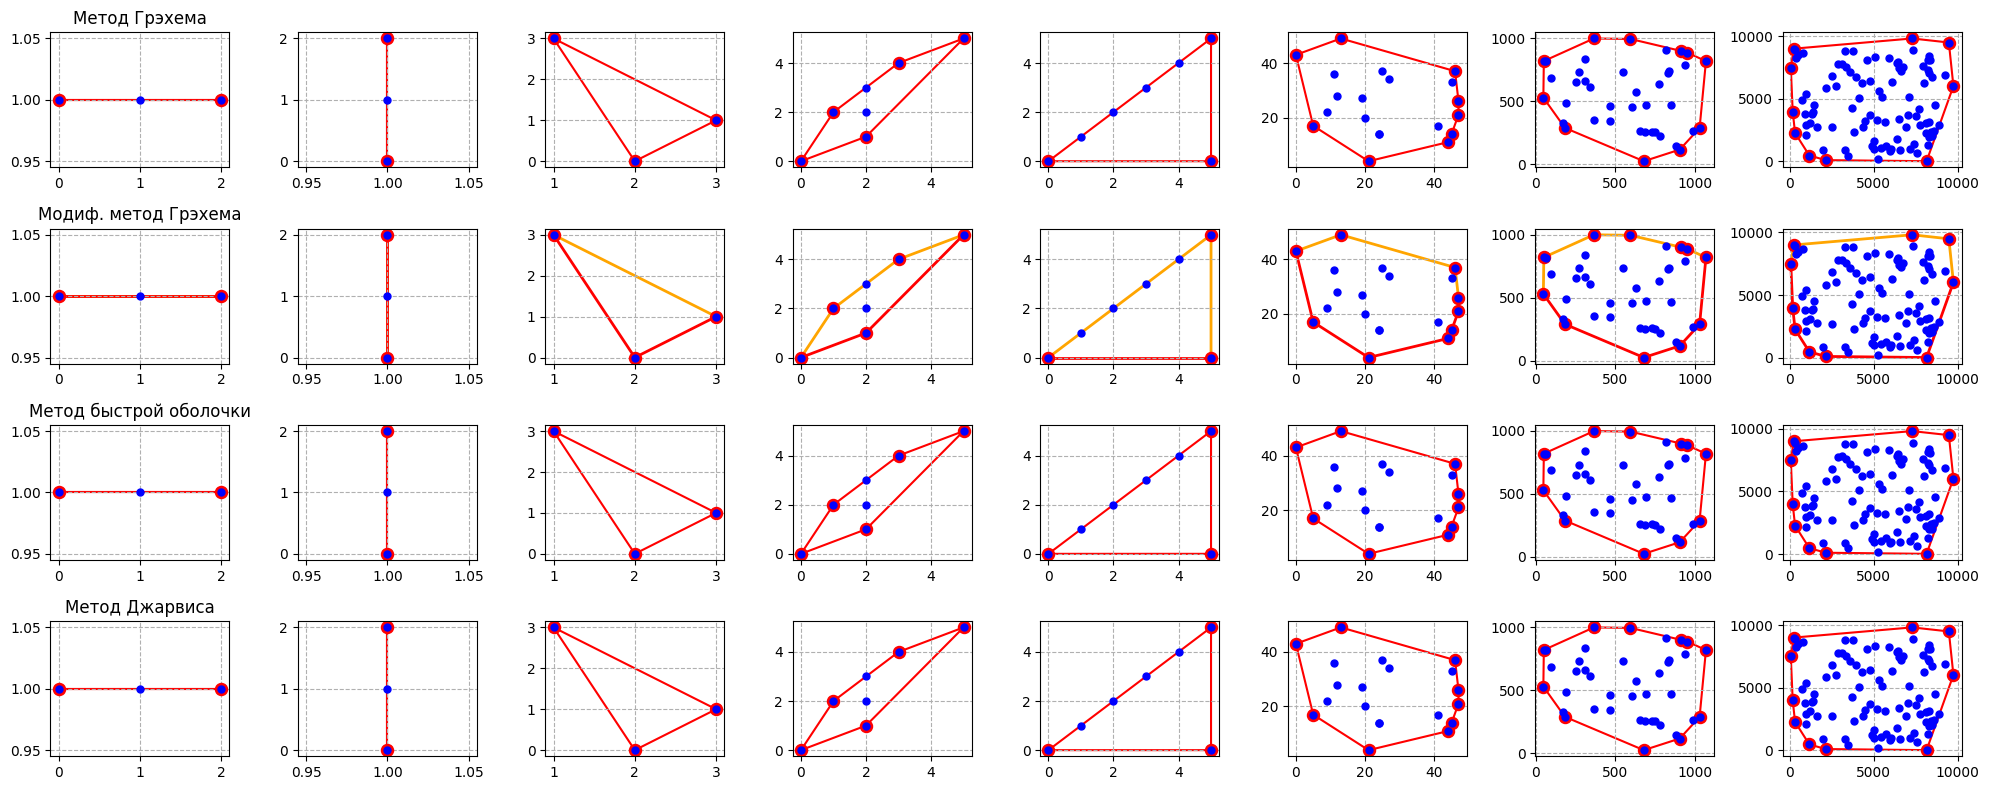

In [ ]:
# Создание полотна 4x8 с подграфиками
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 8))

for i in range(4):
    if i == 1:
        for j, points in enumerate(points_list_demonstration):
              result = graham_scan_modified(points)
              if isinstance(result, tuple):
                  upper_hull, lower_hull, convex_hull = result

                  # Разделение координатных значений для построения графика
                  x, y = zip(*points)
                  up_hull_x, up_hull_y = zip(*upper_hull)
                  lw_hull_x, lw_hull_y = zip(*lower_hull)
                  hull_x, hull_y = zip(*convex_hull)
              else:
                  convex_hull = result
                  x, y = zip(*points)
                  hull_x, hull_y = zip(*convex_hull)

              # Построение графика
              ax = axes[i, j]
              ax.scatter(x, y, color='blue', label='Точки множества', s=25, zorder=3)
              ax.scatter(hull_x, hull_y, color='red', label='Вершины выпуклой оболочки', s=75, zorder=2)
              if isinstance(result, tuple):
                  ax.plot(up_hull_x, up_hull_y, color='orange', linestyle='-', label='Верхняя выпуклая оболочка', linewidth=2, zorder=1)
                  ax.plot(lw_hull_x, lw_hull_y, color='red', linestyle='-', label='Нижняя выпуклая оболочка', linewidth=2, zorder=1)
              else:
                  ax.plot(hull_x, hull_y, color='red', linestyle='-', label='Выпуклая оболочка', linewidth=2, zorder=1)
              if j == 0:
                ax.set_title('Модиф. метод Грэхема')
              ax.grid(True, linestyle='--')
    else:
        for j, points in enumerate(points_list_demonstration):
            match i:
                case 0:
                    convex_hull = graham_scan(points)
                case 2:
                    convex_hull = quick_hull(points)
                case 3:
                    convex_hull = jarvis_march(points)

            # Разделение координатных значений для построения графика
            x, y = zip(*points)
            hull_x, hull_y = zip(*convex_hull)

            # Построение графика
            ax = axes[i, j]
            ax.scatter(x, y, color='blue', label='Точки множества', s=25, zorder=3)
            ax.scatter(hull_x, hull_y, color='red', label='Вершины выпуклой оболочки', s=75, zorder=2)
            ax.plot(hull_x + (hull_x[0],), hull_y + (hull_y[0],), color='red', linestyle='-', label='Выпуклая оболочка', zorder=1)
            if j == 0:
                match i:
                    case 0:
                        ax.set_title('Метод Грэхема')
                    case 2:
                        ax.set_title('Метод быстрой оболочки')
                    case 3:
                        ax.set_title('Метод Джарвиса')
            ax.grid(True, linestyle='--')

# Регулируем расположение подграфиков
plt.tight_layout()

# Показываем графики
plt.show()

In [ ]:
# Создание списка множеств точек для демонстрации скорости работы алгоритмов при большом количестве точек
num_tests = 1000
points_list_test = []
for _ in range(num_tests):
  points_list_test.append(generate_random_points(randint(50, 500), 25, 0, 90000, 0, 100000))
  #points_list_test.append(generate_random_points(randint(10, 50), 25, 0, 1000, 0, 1100))

In [ ]:
num_methods = 4

# Создаем массив для хранения результатов
results = np.zeros((num_methods, num_tests))
method_names = ["graham_scan", "graham_scan_mod", "quick_hull", "jarvis_march"]

for i in range(num_methods):
    start_time = time.time()

    match i:
        case 0:
            for j, points in enumerate(points_list_test):
                convex_hull = graham_scan(points)

                end_time = time.time()
                execution_time = end_time - start_time

                results[i, j] = execution_time
        case 1:
            for j, points in enumerate(points_list_test):
                convex_hull = graham_scan_modified(points)

                end_time = time.time()
                execution_time = end_time - start_time

                results[i, j] = execution_time
        case 2:
            for j, points in enumerate(points_list_test):
                convex_hull = quick_hull(points)

                end_time = time.time()
                execution_time = end_time - start_time

                results[i, j] = execution_time
        case 3:
            for j, points in enumerate(points_list_test):
                convex_hull = jarvis_march(points)

                end_time = time.time()
                execution_time = end_time - start_time

                results[i, j] = execution_time

# Выводим массив результатов
print("Results:")
print(results)

for method, result in zip(method_names, results):
    sum_value = sum(result)
    average_value = sum(result) / len(result)
    print(f"{method:}:")
    print(f"  time summary: {sum_value:.5f}")
    print(f"  average time: {average_value:.5f}")

Results:
[[2.28381157e-03 3.73315811e-03 6.40749931e-03 ... 1.27083778e+00
  1.27121711e+00 1.27167845e+00]
 [1.13463402e-03 2.30455399e-03 3.51285934e-03 ... 1.13940883e+00
  1.14047956e+00 1.14157057e+00]
 [1.16043091e-02 2.26655006e-02 3.51729393e-02 ... 1.24135756e+01
  1.24193265e+01 1.24246776e+01]
 [4.11081314e-03 8.14270973e-03 1.26750469e-02 ... 3.82238841e+00
  3.82427812e+00 3.82622814e+00]]
graham_scan:
  time summary: 692.15493
  average time: 0.69215
graham_scan_mod:
  time summary: 569.64667
  average time: 0.56965
quick_hull:
  time summary: 5560.51720
  average time: 5.56052
jarvis_march:
  time summary: 1921.19654
  average time: 1.92120


In [ ]:
num_methods = 4

# Создаем массив для хранения результатов
results = np.zeros((num_methods, num_tests))
method_names = ["graham_scan", "graham_scan_mod", "quick_hull", "jarvis_march"]

for i in range(num_methods):
    start_time = time.time()

    match i:
        case 0:
            for j, points in enumerate(points_list_test):
                convex_hull = graham_scan(points)

                end_time = time.time()
                execution_time = end_time - start_time

                results[i, j] = execution_time
        case 1:
            for j, points in enumerate(points_list_test):
                convex_hull = graham_scan_modified(points)

                end_time = time.time()
                execution_time = end_time - start_time

                results[i, j] = execution_time
        case 2:
            for j, points in enumerate(points_list_test):
                convex_hull = quick_hull(points)

                end_time = time.time()
                execution_time = end_time - start_time

                results[i, j] = execution_time
        case 3:
            for j, points in enumerate(points_list_test):
                convex_hull = jarvis_march(points)

                end_time = time.time()
                execution_time = end_time - start_time

                results[i, j] = execution_time

# Выводим массив результатов
print("Results:")
print(results)

for method, result in zip(method_names, results):
    sum_value = sum(result)
    average_value = sum(result) / len(result)
    print(f"{method:}:")
    print(f"  time summary: {sum_value:.5f}")
    print(f"  average time: {average_value:.5f}")

Results:
[[1.52349472e-03 1.54564381e-02 2.42395401e-02 ... 4.28545022e+00
  4.28625536e+00 4.28718495e+00]
 [2.19440460e-03 4.76765633e-03 7.07411766e-03 ... 1.87453961e+00
  1.87516642e+00 1.87588835e+00]
 [1.65131092e-02 2.79133320e-02 4.03692722e-02 ... 1.25828307e+01
  1.25882032e+01 1.25934963e+01]
 [4.10246849e-03 8.10766220e-03 1.25746727e-02 ... 3.82172441e+00
  3.82361913e+00 3.82554746e+00]]
graham_scan:
  time summary: 2441.35706
  average time: 2.44136
graham_scan_mod:
  time summary: 1209.65772
  average time: 1.20966
quick_hull:
  time summary: 6108.51025
  average time: 6.10851
jarvis_march:
  time summary: 1926.65286
  average time: 1.92665
